<a href="https://colab.research.google.com/github/soheekim911/Standalone_DL/blob/master/assignment06_LSTM_sotckprice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.0.1.post2
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
!mkdir results

In [0]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('028050.KS', 'yahoo', start, end)

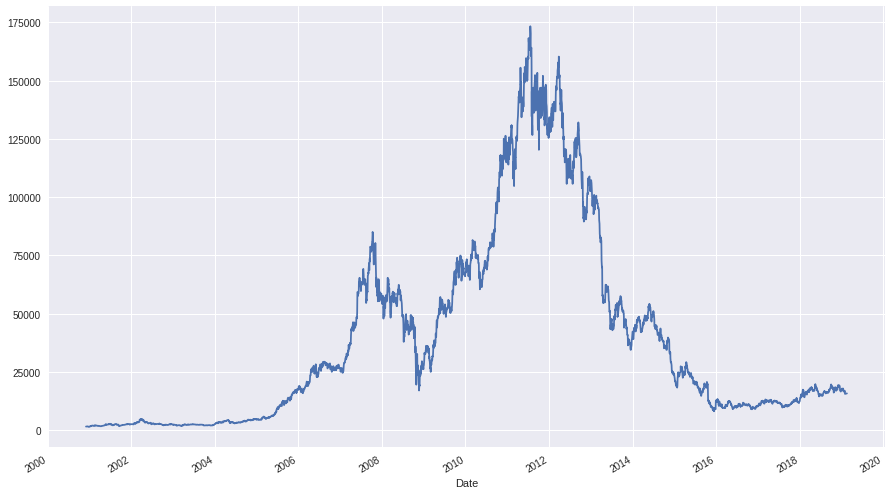

In [5]:
google.Low.plot(grid=True)

In [6]:
google.tail()
print(google.isna().sum())

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64


## Data Preparation

In [0]:
## torch.utils.data.Dataset 사용해서 dataset 새로 정의하기
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames,start,end): 
        # x_frames랑 y_frames는 x와 y의 sequence length
        # x_frames: 최근 n일의 데이터, y_frames: 이후 n일의 데이터
        
        self.symbol = symbol
        self.x_frames = x_frames 
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start) 
        self.end = datetime.datetime(*end)
        
        # 위에서 본 pandas dataframe이 data에 저장됨
        self.data = pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
#         print(self.data.isna().sum) # df 안의 NaN 갯수를 알려주는 구문
        
    def __len__(self): # batch로 묶어주려면 전체 dataset길이를 알아야하기 때문에
        return len(self.data) - (self.x_frames + self.y_frames) + 1
        #만약 1,2,3,4,5일 데이터가 있고 2일 주고 2일 예측하라고 하려면
        #1,2 - 3,4랑
        #2,3 - 4,5 두 개의 sequence 만드는 것이 가능
    def __getitem__(self, idx): # dataset에 i번째 요청이 왔을 때 그것을 반환하도록 인덱싱
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames] 
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']] # column 순서 고정
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1)) # trend는 같은데 scale만 다른 경우를 똑같이 학습하도록(나는 추세만 보면 되니까)'비율'로 normalize함
        # normalize 방법: 데이터를 모두 마지막 날짜 가격으로 나눠줌. 굳이 log 쓰는 건 나누기 쓸 경우 0으로 나눠지는 경우가 있어서 피하려고.
        data = data.values # pd.dataframe --> np.array
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

x는 벡터의 시퀀스. 
DataSet: i번째 벡터를 리턴하는 역할
DataLoader: dataset이 리턴한 것을 배치 단위로 묶어줌

In [6]:
dataset = StockDataset('028050.KS', 10, 5, (2000,1,1), (2005, 1,1))
dataloader = DataLoader(dataset,2)
for X, y in dataloader:
    print(X.shape, y.shape)
    break

torch.Size([2, 10, 6]) torch.Size([2, 5, 6])


## Model Define

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor() # 여기서 out_dim
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self): # hid_dim to out_dim
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden) #맨 마지막에 y로 보낼 ht, 각 time step의 결과값
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1)) # 맨 마지막 output, batch size로 reshaping
        return y_pred


In [0]:
# Loss는 MSE를 쓰지만 평가 metric은 Mean Absolute Loss를 사용. 
# 차이의 절대값의 합. MSE가 아닌 이유는, 

def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

## Train, Validate, Test

In [0]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'],
                            batch_size = args.batch_size,
                            shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    train_acc = 0.0 # 위에서 정의한 metric 값.
    train_loss = 0.0
    
    for i, (X, y) in enumerate(trainloader):
        # sequence lenth가 맨 앞으로 나오고 그 다음 batch size 순서 되도록 transpose
        X = X.transpose(0,1).float().to(args.device)
        y_true = y[:,:,3].float().to(args.device) # 예측은 종가(세번째에 있음)만 하려고 3번째 column 가져옴
        #print(torch.max(X[:, :, 3]), torch.max(y_true))
        
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc
        

In [0]:
def validate(model, partiiton, loss_fn, args):
    valloader = DataLoader(partition['val'],
                          batch_size=args.batch_size,
                          shuffle=False, drop_last=True)
    
    model.eval()
    
    val_acc = 0.0
    val_loss = 0.0
    
    with torch.no_grad():
        for i, (X,y) in enumerate(valloader):
            
            X = X.transpose(0,1).float().to(args.device)
            y_true = y[:,:,3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]
            
            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [0]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [33]:
print(partition)

{'train': <__main__.StockDataset object at 0x7fad2172c710>, 'val': <__main__.StockDataset object at 0x7fad21714198>, 'test': <__main__.StockDataset object at 0x7fad21899d68>}


In [0]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

#     print(type(model), type(partition))
    test_acc = test(model, partition, args)    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
        

## Manage Experiment

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [0]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [0]:
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

## Exp1. original code

In [47]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 5.15/5.78, Loss(train/val) 0.00663/0.00367. Took 18.46 sec
Epoch 1, Acc(train/val): 2.65/4.73, Loss(train/val) 0.00347/0.00313. Took 18.46 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=2, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 4.56/3.64, Loss(train/val) 0.00811/0.00275. Took 18.51 sec
Epoch 1, Acc(train/val): 2.53/3.03, Loss(train/val) 0.00342/0.00257. Took 18.39 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=0.001, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


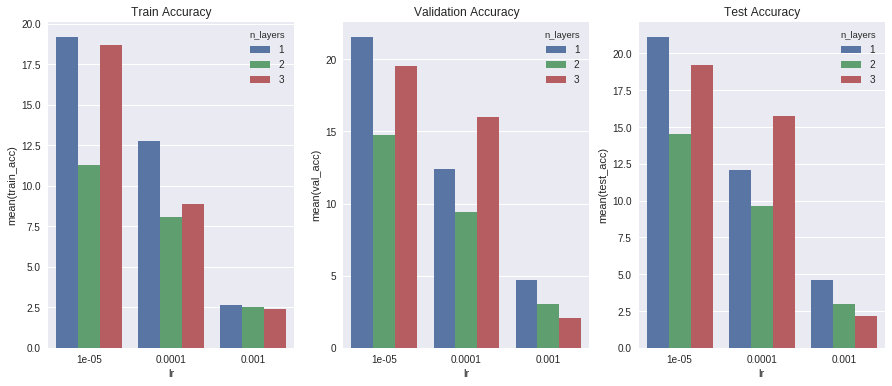

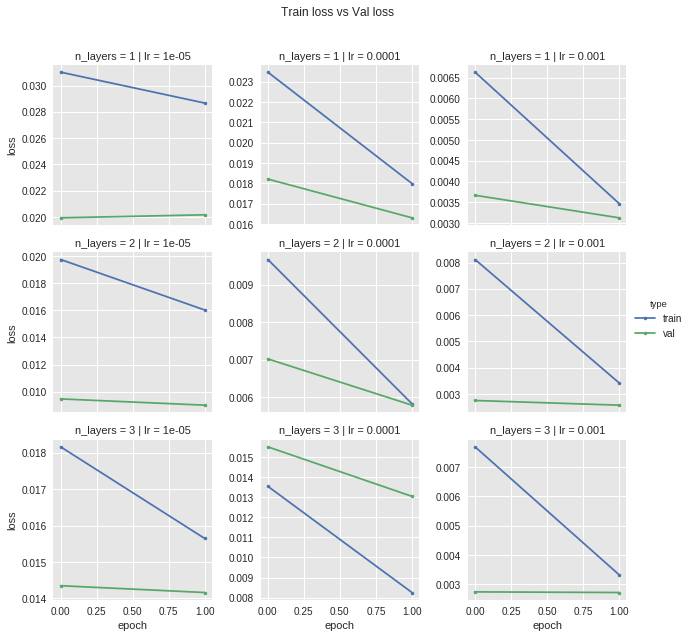

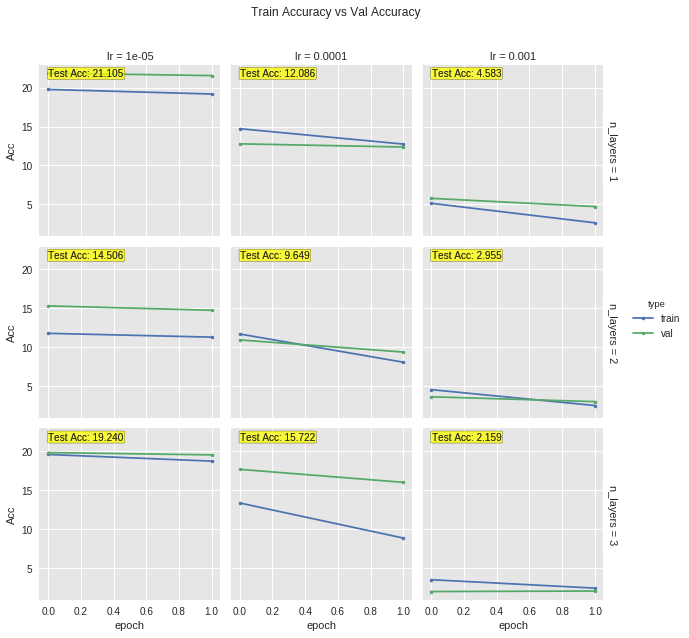

In [48]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

learning rate 은 0.0000일 때 가장 높았으므로 고정하고, 그 떄 layer 수가 1,3개일 때가 2개일 때보다 높으므로 n_layer = 1 또는 3으로 놓고 optimizer를 바꿔가며 실험해보자

## Exp2. Optimizer & number of layers

In [50]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_optim"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 512
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.00005
args.epoch = 5


# ====== Experiment Variable ====== #
name_var1 = 'optim'
name_var2 = 'n_layers'
list_var1 = ['RMSprop','SGD','Adam']
list_var2 = [1,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=512, device='cuda', dropout=0.0, epoch=5, exp_name='exp2_optim', hid_dim=50, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 18.14/17.96, Loss(train/val) 0.02294/0.01551. Took 14.81 sec
Epoch 1, Acc(train/val): 17.19/17.69, Loss(train/val) 0.01936/0.01496. Took 14.76 sec
Epoch 2, Acc(train/val): 16.53/17.47, Loss(train/val) 0.01748/0.01454. Took 14.80 sec
Epoch 3, Acc(train/val): 16.03/17.29, Loss(train/val) 0.01632/0.01418. Took 14.63 sec
Epoch 4, Acc(train/val): 15.61/17.14, Loss(train/val) 0.01528/0.01386. Took 14.62 sec
Namespace(batch_size=512, device='cuda', dropout=0.0, epoch=5, exp_name='exp2_optim', hid_dim=50, input_dim=6, l2=1e-05, lr=5e-05, n_layers=3, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 15.33/12.44, Loss(train/val) 0.02801/0.01832. Took 14.59 sec
Epoch 1, Acc(train/val): 13.56/12.17, Loss(train/v

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


IndexError: ignored

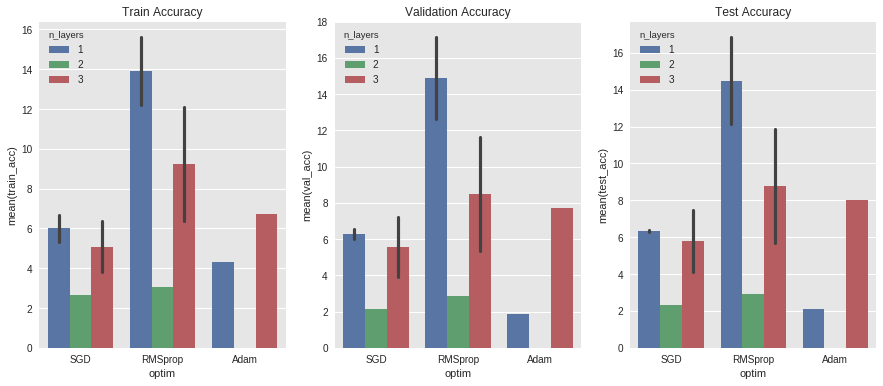

In [51]:
var1 = 'optim'
var2 = 'n_layers'
df = load_exp_result('exp2')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

RMSprop이 전반적으로 가장 높은 acc보임. RMSprop으로 고정하고 hid_dim과 dropout 비율을 조정해보자

## Exp3. hid_dim & dropout

In [52]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_hiddim_dropout"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 512
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.1
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.00005
args.epoch = 5


# ====== Experiment Variable ====== #
name_var1 = 'hid_dim'
name_var2 = 'dropout'
list_var1 = [30,50,100]
list_var2 = [0.1,0.3,0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=512, device='cuda', dropout=0.1, epoch=5, exp_name='exp3_hiddim_dropout', hid_dim=30, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 11.15/8.44, Loss(train/val) 0.03107/0.01912. Took 14.85 sec
Epoch 1, Acc(train/val): 10.84/8.16, Loss(train/val) 0.02810/0.01859. Took 14.64 sec
Epoch 2, Acc(train/val): 10.46/7.95, Loss(train/val) 0.02637/0.01818. Took 14.51 sec
Epoch 3, Acc(train/val): 10.26/7.78, Loss(train/val) 0.02506/0.01784. Took 14.56 sec
Epoch 4, Acc(train/val): 10.07/7.66, Loss(train/val) 0.02467/0.01754. Took 14.65 sec
Namespace(batch_size=512, device='cuda', dropout=0.3, epoch=5, exp_name='exp3_hiddim_dropout', hid_dim=30, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 19.34/15.03, Loss(train/val) 0.04730/0.02259. Took 14.67 sec
Epoch 1, Acc(train/val): 18.47/14.76,

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


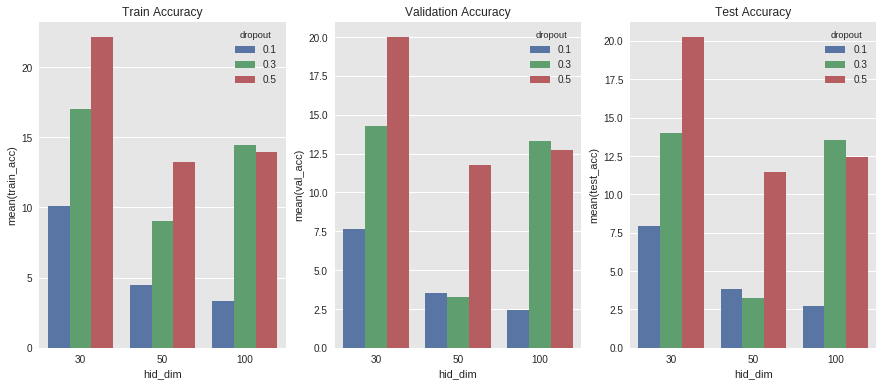

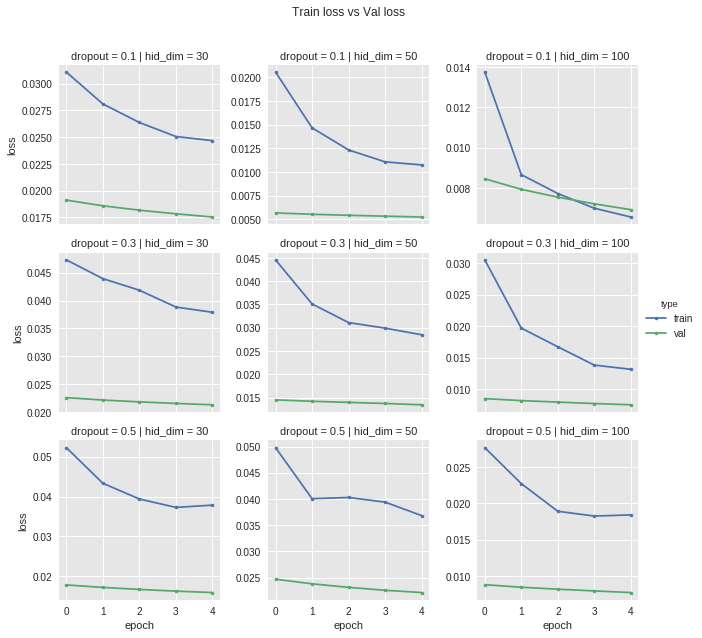

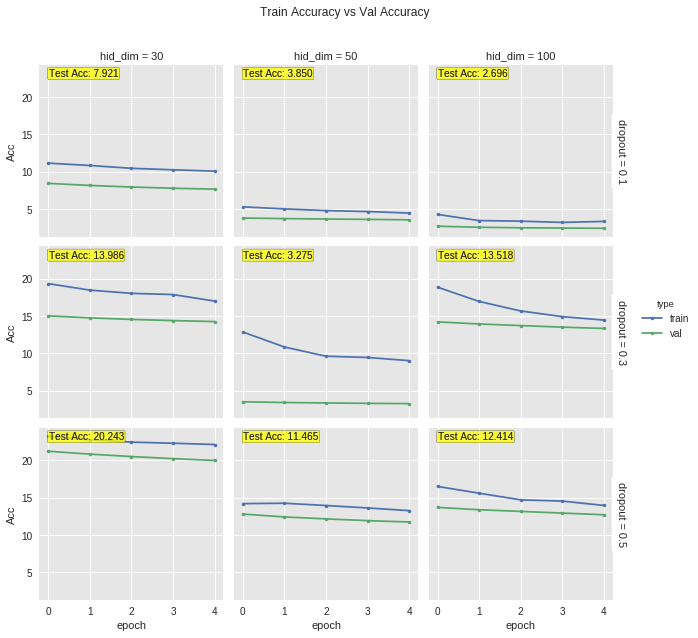

In [54]:
var1 = 'hid_dim'
var2 = 'dropout'
df = load_exp_result('exp3')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

hid_dim이 적을 때는 dropout 비율이 높을 때 정확도 높지만 hid_dim이 100일 때는 그렇지 않다.

## Exp4


In [19]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_hiddim_dropout"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 512
args.x_frames = 5
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 30
args.n_layers = 1

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.1
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.00005
args.epoch = 5


# ====== Experiment Variable ====== #
name_var1 = 'use_bn'
name_var2 = 'dropout'
list_var1 = [True, False]
list_var2 = [0.3,0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(batch_size=512, device='cuda', dropout=0.3, epoch=5, exp_name='exp4_hiddim_dropout', hid_dim=30, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 11.49/8.43, Loss(train/val) 0.03472/0.01914. Took 15.03 sec
Epoch 1, Acc(train/val): 11.23/8.16, Loss(train/val) 0.03242/0.01862. Took 15.06 sec
Epoch 2, Acc(train/val): 10.86/7.96, Loss(train/val) 0.03002/0.01822. Took 15.02 sec
Epoch 3, Acc(train/val): 10.72/7.80, Loss(train/val) 0.02855/0.01790. Took 14.84 sec
Epoch 4, Acc(train/val): 10.51/7.68, Loss(train/val) 0.02755/0.01761. Took 15.01 sec
Namespace(batch_size=512, device='cuda', dropout=0.5, epoch=5, exp_name='exp4_hiddim_dropout', hid_dim=30, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)
Epoch 0, Acc(train/val): 20.94/15.03, Loss(train/val) 0.05752/0.02260. Took 15.04 sec
Epoch 1, Acc(train/val): 19.85/14.75,

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


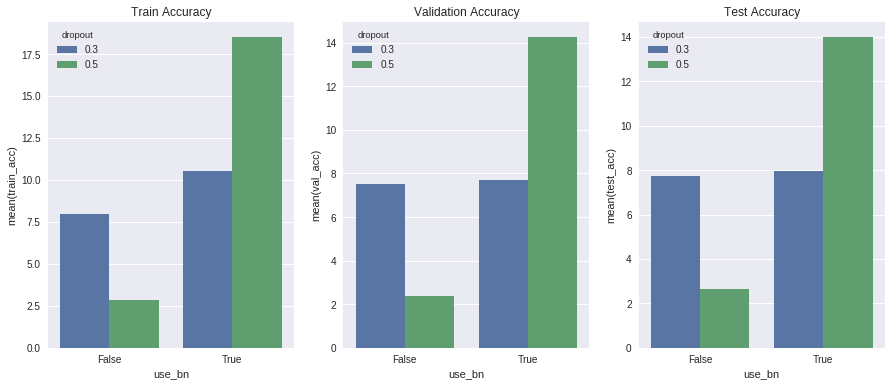

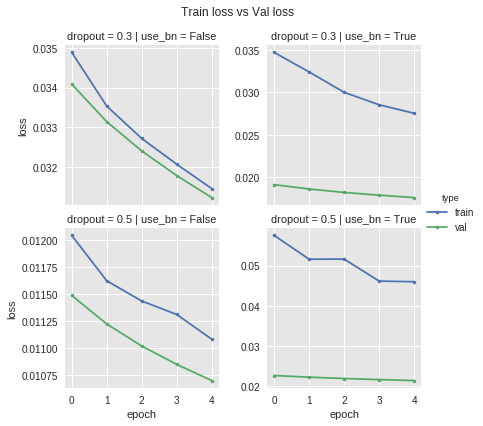

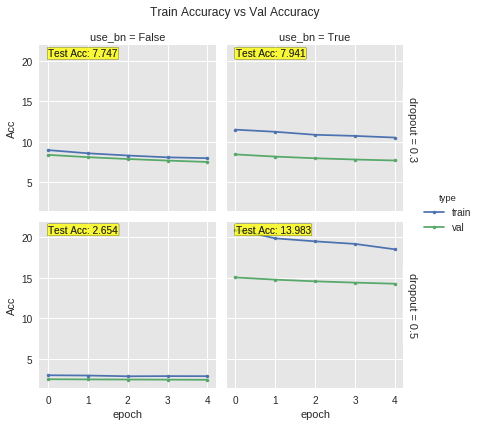

In [20]:
var1 = 'use_bn'
var2 = 'dropout'
df = load_exp_result('exp4')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

가장 좋은 결과는 고정하고 나머지 하이퍼파라미터를 수정하면서 테스트를 해봤는데,  결국 batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=1e-05, lr=1e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5) 조건의 val_acc 21.85퍼센트를 넘지 못했습니다. 

그나마 가장 높은 건 Namespace(batch_size=512, device='cuda', dropout=0.5, epoch=5, exp_name='exp3_hiddim_dropout', hid_dim=30, input_dim=6, l2=1e-05, lr=5e-05, n_layers=1, optim='RMSprop', symbol='028050.KS', use_bn=True, x_frames=5, y_frames=5)에서  val_acc = 21.2가 나온 것이네요.

하나의 조건에서 최적이었더라도 조건이 바뀌면서 다른 결과가 난 것 같은데, 말씀하신대로 좀 더 촘촘하게 파라미터 튜닝을 해야할 것 같습니다.

궁금한 것은, 모든 실험에서 epoch이 증가할수록 Loss는 감소하지만 정확도는 변하지 않거나 떨어지기만 하는데, 왜 두 지표가 같이 움직이지 않는 걸까요?